In [3]:
#data format library
import h5py

#numpy
import numpy as np
import pandas as pd
import numpy.ma as ma
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)
plt.rcParams["font.family"] = "Times New Roman"
# %matplotlib notebook
import sys
sys.path.append('/Users/gautam.sridhar/Documents/Repos/Markov_Fish/utils/')
import matplotlib.colors as pltcolors
import os
import copy
import clustering_methods as cl
import operator_calculations as op_calc
import delay_embedding as embed
import stats
import time

np.random.seed(42)

import importlib
importlib.reload(op_calc)

<module 'operator_calculations' from '/Users/gautam.sridhar/Documents/Repos/Markov_Fish/utils/operator_calculations.py'>

In [4]:
condition_labels = ['Light (5x5cm)','Light (1x5cm)','Looming(5x5cm)','ChasingDot coarsespeeds(5x5cm)','ChasingDot finespeeds(5x5cm)','Dark_Transitions(5x5cm)',
                    'Phototaxis','Optomotor Response (1x5cm)','Optokinetic Response (5x5cm)','Dark (5x5cm)','3 min Light<->Dark(5x5cm)',
                    'Prey Capture Param. (2.5x2.5cm)','Prey Capture Param. RW. (2.5x2.5cm)',
                    'Prey Capture Rot.(2.5x2.5cm)','Prey capture Rot. RW. (2.5x2.5cm)','Light RW. (2.5x2.5cm)']

condition_recs = np.array([[515,525],[160,172],[87,148],[43,60],[22,43],[60,87],
                           [202,232],[148,160],[172,202],[505,515],[0,22],
                           [232,301],[347,445],[301,316],[316,347],
                           [445,505]])

In [39]:
conditions = np.zeros((np.max(condition_recs),2),dtype='object')
for k in range(len(condition_recs)):
    t0,tf = condition_recs[k]
    conditions[t0:tf,0] = np.arange(t0,tf)
    conditions[t0:tf,1] = [condition_labels[k] for t in range(t0,tf)]

In [40]:
recs_remove = np.load('/Users/gautam.sridhar/Documents/Repos/ZebraBouts/Datasets/Full_Data/recs_remove.npy')

In [41]:
recs_remove = np.hstack([recs_remove, np.arange(22,60)])

In [42]:
print(recs_remove)

[ 90 260 264 270 276 352 358 364 375 381 383 392 398 404 410 416 422 427
 433 439 450 456 467 497  22  23  24  25  26  27  28  29  30  31  32  33
  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51
  52  53  54  55  56  57  58  59]


In [43]:
conditions = np.delete(conditions, recs_remove,axis=0)

In [10]:
## Load symbolic sequences

path_to_filtered_data = '/Users/gautam.sridhar/Documents/Repos/Markov_Fish/Datasets/JM_Data/'
f = h5py.File(path_to_filtered_data + 'kmeans_labels_K5_N1200_s8684.h5')
lengths_all = np.array(f['MetaData/lengths_data'], dtype=int)
labels_fish_allrec = ma.array(f['labels_fish'],dtype=int)
state_trajs = ma.array(f['state_trajs'])
f.close()

# lengths_all = np.load('/Users/gautam.sridhar/Documents/Repos/ZebraBouts/Datasets/Full_Data/lengths_ex2_recordings.npy')
# lengths_all = lengths

In [11]:
# recs_ = np.asarray(conditions[:,0], dtype=int)

to_mask = 1300

# maxL = np.max(lengths_all[recs_])
maxL = np.max(lengths_all)

labels_fish_allrec[labels_fish_allrec == to_mask] = ma.masked

# labels_fishrec = to_mask * ma.ones((len(recs_), maxL))
# labels_fishrec = labels_fish_allrec[recs_,:maxL+2]
# labels_fishrec = np.delete(labels_fishrec,4,0)

# labels_fishrec[labels_fishrec == to_mask] = ma.masked
labels_fish = labels_fish_allrec

# lengths_rem = np.delete(lengths_all, recs_remove)
lengths_rem = lengths_all

In [12]:
## Select Dataset
np.random.seed(42)
seeds = np.random.randint(0,10000,100)
delay_range = np.arange(1,20,1)
dt = 1
div= 463
n_modes=50
labels_all= ma.concatenate(labels_fish,axis=0)
print(labels_fish.shape)

(463, 11651)


In [13]:
P_ensemble = np.load('/Users/gautam.sridhar/Documents/Repos/ZebraBouts/Datasets/Full_Data/P_ensemble_ex8_N1200_s8684.npy')

In [14]:
from scipy.sparse import diags,identity,coo_matrix, csr_matrix
P_ensemble = csr_matrix(P_ensemble)

In [15]:
import msmtools.estimation as msm_estimation
delay = 3
dt = 1
print(delay)
# lcs_ensemble,P_ensemble = op_calc.transition_matrix(labels_all,delay,return_connected=True)
lcs_ensemble = msm_estimation.largest_connected_set(P_ensemble)
inv_measure = op_calc.stationary_distribution(P_ensemble)
final_labels = op_calc.get_connected_labels(labels_all,lcs_ensemble)
R = op_calc.get_reversible_transition_matrix(P_ensemble)
eigvals,eigvecs = op_calc.sorted_spectrum(R,k=10,seed=123)
sorted_indices = np.argsort(eigvals.real)[::-1]
eigvals = eigvals[sorted_indices][1:].real
eigvals[np.abs(eigvals-1)<1e-12] = np.nan
eigvals[eigvals<1e-12] = np.nan
t_imp =  -(delay*dt)/np.log(np.abs(eigvals))
eigfunctions = eigvecs.real/np.linalg.norm(eigvecs.real,axis=0)
eigfunctions_traj = ma.array(eigfunctions)[final_labels,:]
eigfunctions_traj[final_labels.mask] = ma.masked

3


In [178]:
path_to_filtered_data = '/Users/gautam.sridhar/Documents/Repos/ZebraBouts/Results/'
f = h5py.File(path_to_filtered_data + 'pool_ex8_PCs/Cross_val.h5')
print(f.keys())
best_alphas = np.array(f['best_alphas'])
test_acc = np.array(f['test_acc'])
train_acc = np.array(f['train_acc'])
conf_matrices_full = np.array(f['conf_matrices'])
# labels_fish_allrec = ma.array(f['labels_fish'],dtype=int)
# state_trajs = ma.array(f['state_trajs'])
f.close()

<KeysViewHDF5 ['best_alphas', 'conf_matrices', 'test_acc', 'train_acc']>


In [179]:
model_test_acc = []
for i in range(33):
    model_test_acc.append(test_acc[i*100:i*100+100])
    
model_train_acc = []
for i in range(33):
    model_train_acc.append(train_acc[i*100:i*100+100])

In [180]:
n_states = np.array([2,3,4,5,6,7,8,9])
n_states = np.append(n_states, np.round(np.logspace(1,3,25,base=10)).astype(int))

NameError: name 'accuracy_score' is not defined

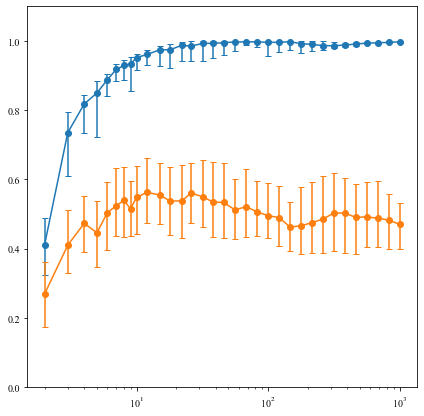

In [234]:
# Accuracy train v test

fig, ax = plt.subplots(1,1, figsize=(7,7))
mean,cil,ciu = np.vstack(model_train_acc).mean(axis=1),np.percentile(np.vstack(model_train_acc),2.5,axis=1),np.percentile(np.vstack(model_train_acc),97.5,axis=1)
ax.errorbar(n_states,mean,yerr = [mean-cil,ciu-mean],marker='o',capsize=3)

mean,cil,ciu = np.vstack(model_test_acc).mean(axis=1),np.percentile(np.vstack(model_test_acc),2.5,axis=1),np.percentile(np.vstack(model_test_acc),97.5,axis=1)

ax.errorbar(n_states,mean,yerr = [mean-cil,ciu-mean],marker='o',capsize=3)
ax.set_xscale('log')
ax.set_ylim(0,1.1)
# ax.axhline(accuracy_score(y_test, np.random.choice(y_test, len(y_test) ,replace=False)),c='k')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Fig4/Nstate_logreg_new.pdf')

# plt.xlim(0,20)

In [183]:
print(conf_matrices_full[i].shape)

(14, 14)


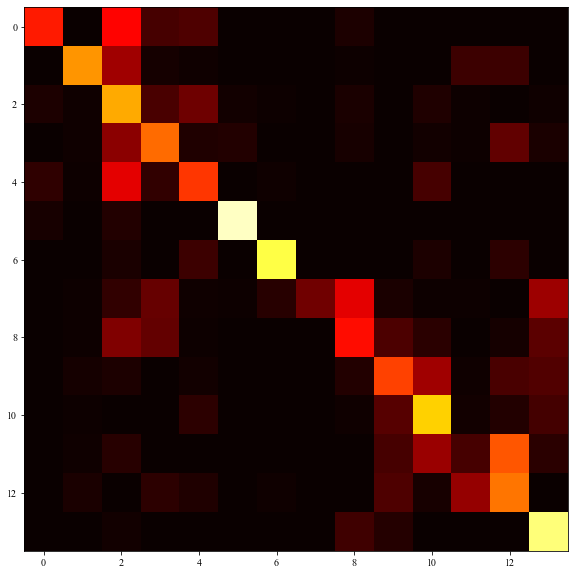

In [233]:
# Confusion Matrix at particular q

fig,ax = plt.subplots(1,1, figsize=(10,10))

normcfs = []
for i in range(1100,1200):
    normcfs.append(conf_matrices_full[i]/np.sum(conf_matrices_full[i],axis=1)[:,np.newaxis])
avg_normcf = np.mean(normcfs,axis=0)

# normcf = conf_matrices_full[304]/np.sum(conf_matrices_full[304],axis=1)[:,np.newaxis]
a = ax.imshow(avg_normcf, cmap='hot', vmax = 1., vmin=0.)
plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Fig4/qstate_conf_mar.pdf')


# fig.colorbar(a)

In [16]:
# Transition matrix based calculations

from scipy.spatial import distance
from sklearn.cluster import KMeans

n_state = 7
kms = np.load('/Users/gautam.sridhar/Documents/Repos/ZebraBouts/Results/pool_ex8_PCs/cg{}_labels.npy'.format(n_state))
# kms = coh_labels_phi1

cluster_traj_all = ma.copy(final_labels)
cluster_traj_all[~final_labels.mask] = ma.array(kms)[final_labels[~final_labels.mask]]
cluster_traj_all[final_labels.mask] = ma.masked

cluster_fish = cluster_traj_all.reshape(labels_fish.shape[0],labels_fish.shape[1])
cluster_fish_mask = cluster_fish.mask

print(cluster_fish.shape)


P_prj = ma.zeros((labels_fish.shape[0],n_state,n_state))
lcs_all = []
for cf in range(labels_fish.shape[0]):
    print(cf)
    lcs_spec,P_spec = op_calc.transition_matrix(cluster_fish[cf],delay=3, return_connected=True)
    lcs_all.append(lcs_spec.astype(int))
    for i,l in enumerate(lcs_spec):
        P_prj[cf, l,lcs_spec] = P_spec.todense()[i]

(463, 11651)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
2

In [17]:
def polygon(sides, radius=1, rotation=0, translation=None):
    one_segment = np.pi * 2 / sides

    points = [
        (np.sin(one_segment * i + rotation) * radius,
         np.cos(one_segment * i + rotation) * radius)
        for i in range(sides)]

    if translation:
        points = [[sum(pair) for pair in zip(point, translation)]
                  for point in points]

    return points

from matplotlib import patches
def draw_curved_arrow(idx0,point0,point1,hw,angle,color_array):
    style = "Simple, tail_width={}, head_width={}, head_length={}".format(hw,5*hw,7.5*hw)
    kw = dict(arrowstyle=style, color=color_array[idx0])
    a = patches.FancyArrowPatch(point0, point1,
                                 connectionstyle="arc3,rad={}".format(angle), **kw)
    plt.gca().add_patch(a)

def get_angle_array(idx,n_states):
    idx=0
    angle_array = np.zeros(n_states)
    for k in range(3):
        angle_array[idx-k-1]=.3*kx+k*.05
        if idx+k>n_states-1:
            angle_array[k-n_states+idx] = -.3*kx-k*.05
        else:
            angle_array[idx+k]=-.35*kx-k*.01
    return angle_array


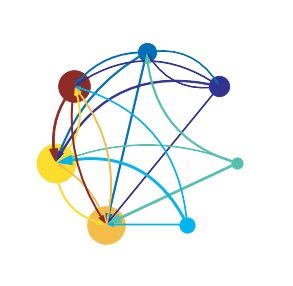

In [122]:
n_states=7
st_colors = ['#006FB8','#313390','#52C1AF','#00B4F0','#F4BD48','#FBDD2B','#8D2B24']
# st_colors = ['C0','C1','C2','C3','C4','C5','C6','C7',]

points = polygon(n_states)

Pc_d = copy.deepcopy(P_prj[51])
ih = op_calc.stationary_distribution(Pc_d)
# np.fill_diagonal(Pc_d, 0)
Pc_d[Pc_d<1e-1]=0
plt.figure(figsize=(5,5))
for k in range(n_states):
    plt.scatter(points[k][0],points[k][1],s=5000*ih[k],c=st_colors[k], zorder=0)
kx=-1
for idx in range(n_states):
    angle_array = get_angle_array(idx,n_states)*kx
    trans_indices = np.arange(0,n_states)
    trans_indices = trans_indices[trans_indices!=idx]
    for kj,j in enumerate(trans_indices):
        
        draw_curved_arrow(idx,points[idx],points[j],5*Pc_d[idx,j],angle_array[kj],st_colors)
    kx=kx*-1
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.axis('off')
plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Fig4/tmat_eg_51.pdf')
plt.show()

In [121]:
# L1 distance
mean_js = ma.zeros((P_prj.shape[0],P_prj.shape[0]))
for cf1 in range(P_prj.shape[0]):
    print(cf1)      
    for cf2 in range(cf1+1):
        mean_js[cf1,cf2] = np.average(np.sum(np.abs(P_prj[cf1] - P_prj[cf2]), axis=1))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

(-0.5, 462.5, 462.5, -0.5)

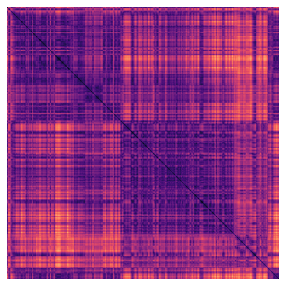

In [23]:
# tot_js_full = (tot_js+tot_js.T)/2
fig, ax = plt.subplots(1,1, figsize=(5,5))
mean_js_full = (mean_js+mean_js.T)
im = ax.imshow(mean_js_full,vmax = 1.8, cmap = 'magma')
# fig.colorbar(im)
ax.axis('off')
# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Fig4/tmat_distances.pdf')
# fig.colorbar(im, ax=ax)

In [24]:
denoised_distmat_c = np.zeros(mean_js_full.shape)
denoised_distmat_c[:20,:20] = mean_js_full[443:463, 443:463]
denoised_distmat_c[:20,20:] = mean_js_full[443:463, :-20]
denoised_distmat_c[20:,:20] = mean_js_full[:-20, 443:463]

idx = np.where(conditions[:,0] < 443)[0]
denoised_distmat_c[20:,20:] = mean_js_full[idx,:-20]

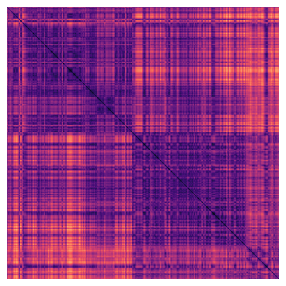

In [26]:
# tot_js_full = (tot_js+tot_js.T)/2
fig, ax = plt.subplots(1,1, figsize=(5,5))
im = ax.imshow(denoised_distmat_c,vmax = 1.8,cmap = 'magma')
# fig.colorbar(im)
ax.axis('off')
# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Fig4/tmat_distances.pdf')
# fig.colorbar(im, ax=ax)

### Constant Shift Embedding for visualization

In [27]:
def CSE(D):
    """
    Perform constant shift embedding and return eigenvalues and eigenvectors on a distance matrix 
    """
    n = D.shape[0]
    
    Q = np.eye(n) - (1/n)*np.dot(np.ones((n,1)), np.ones((1,n)))
    # print(Q)
    Sc = -0.5*(np.dot(Q,np.dot(D,Q)))
    ei1, _ = np.linalg.eig(Sc)
    Dtilde = D - 2*(np.min(ei1))*(np.dot(np.ones((n,1)), np.ones((1,n))) - np.eye(n))

    Sctilde = -0.5*(np.dot(Q,np.dot(Dtilde,Q)))
    ei_fin, ev = np.linalg.eig(Sctilde)
    sorted_idx = np.argsort(ei_fin)[::-1]
    ei_fin = ei_fin[sorted_idx].real
    ev = ev[:,sorted_idx].real
    
    return ei_fin, ev

In [28]:
# Convert to similarity and extracting Euclidean embedding
ei_fin, ev = CSE(mean_js_full)

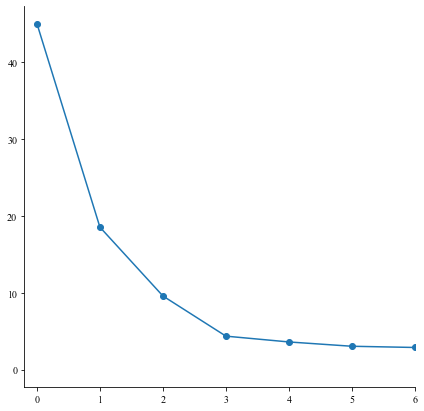

In [29]:
# Visualize eigenvalues of CSE to check dimensions
fig, ax = plt.subplots(1,1,figsize=(7,7))
ax.plot(ei_fin ,marker='o')
ax.set_xlim(-0.2,6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [30]:
Xp = np.dot(ev[:,:4], np.sqrt(np.diag(ei_fin[:4])))

Light (5x5cm)
[453 454 455 456 457 458 459 460 461 462]


<ipython-input-48-a6fd1f23cf78>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['',''], fontsize=30)
<ipython-input-48-a6fd1f23cf78>:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['',''], fontsize=30)


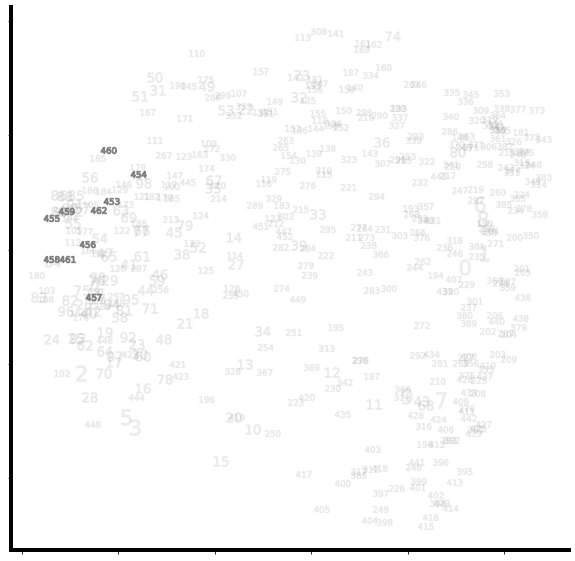

In [48]:
# colors1_ = plt.cm.autumn(np.linspace(0.0,1.,11))
# colors2_ = plt.cm.winter(np.linspace(0.,1.,5))
# colors_ = np.vstack([colors1_,colors2_])

# colors_range= plt.cm.rainbow(np.linspace(0,1,3))
# colors_ = colors_range[tmspace_cluster]

colors1_ = plt.cm.Set3(np.linspace(0.0,1.,11))
colors2_ = plt.cm.cool(np.linspace(0.0,1.,5))
colors_ = np.vstack([colors1_,colors2_])

cond = 0
print(condition_labels[cond])
cond_recs = np.where(conditions[:,1] == condition_labels[cond])[0]
print(cond_recs)

fig, ax = plt.subplots(1,1,figsize=(10,10))
# ax = plt.axes(projection='3d')
# ax.scatter(-1*Xp[:,2].real, -1*Xp[:,3].real, c=cluster_labels_tmat,s=250)
for i in range(463):
    alpha=0.1
    if i in cond_recs:
        alpha = 1.
    ax.scatter(-1*Xp[i,0].real,-1*Xp[i,1].real,color='grey',s=250, alpha=alpha,marker='${}$'.format(i))


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# ax.view_init(45, 40)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(4)
ax.set_xticklabels(['',''], fontsize=30)
ax.set_yticklabels(['',''], fontsize=30)

# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Fig5/Tmat_space_pc.pdf')
plt.show()

In [45]:
### Calculating the epsilon ball for each fish

# labels = labels_all
path_to_filtered_data = '/Users/gautam.sridhar/Documents/Repos/ZebraBouts/Results/'
f = h5py.File(path_to_filtered_data + 'pool_ex8_PCs/simlabels_fish_K5_N1200_tau3_cg7.h5')
sims_fishnum = ma.asarray(f['MetaData/simfishes'], dtype=int)
lengths_sims = ma.asarray(f['MetaData/lengths_sims'], dtype=int)
sims_fish = ma.asarray(f['sim_labels'], dtype=int)
sims_fish_mask = ma.asarray(f['sim_labels_mask'])
f.close()
# to_mask = 1300

# sims_fish[sims_fish == to_mask] = ma.masked
sims_fish[sims_fish_mask.astype(bool)] = ma.masked

In [46]:
print(sims_fish.shape)

(100, 463, 11651)


In [114]:
#Calculate epsilon ball around single fish
n_states=7
delay=1
P_sims = np.zeros((len(sims_fish),n_states,n_states))
rec = 51
lcs_sims = []

for cf in range(len(sims_fish)):
    print(cf)
    lcs_spec,P_spec = op_calc.transition_matrix(sims_fish[cf,rec,:],delay=1, return_connected=True)
    lcs_sims.append(lcs_spec.astype(int))
    for i,l in enumerate(lcs_spec):
        P_sims[cf, l,lcs_spec] = P_spec.todense()[i]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [115]:
mean_js_sims = ma.zeros((P_sims.shape[0], P_prj.shape[0]))
for cf1 in range(P_sims.shape[0]):
    for cf2 in range(P_prj.shape[0]):
        mean_js_sims[cf1,cf2] = np.average(np.sum(np.abs(P_sims[cf1] - P_prj[cf2]), axis=1))

In [116]:
def CSE_project(Dnew, D):
    m = Dnew.shape[0]
    n = D.shape[0]
    
    Q = np.eye(n) - (1/n)*np.dot(np.ones((n,1)), np.ones((1,n)))
    t1 = np.dot(Dnew, Q)
    
    Sc = -0.5*(np.dot(Q,np.dot(D,Q)))
    ei1, _ = np.linalg.eig(Sc)
    Dtilde = D - 2*(np.min(ei1))*(np.dot(np.ones((n,1)), np.ones((1,n))) - np.eye(n))
    
    t2 = np.dot((1/n)*np.dot(np.ones((m,1)), np.ones((1,n))), np.dot(Dtilde,Q))
    
    Scnew = -0.5*(t1-t2)
    
    return Scnew

In [117]:
Scnew = CSE_project(mean_js_sims, mean_js_full)
Xpnew = np.dot(Scnew, np.dot(ev[:,:4], np.sqrt(np.diag(1/ei_fin[:4]))))
# plt.imshow(Scnew)

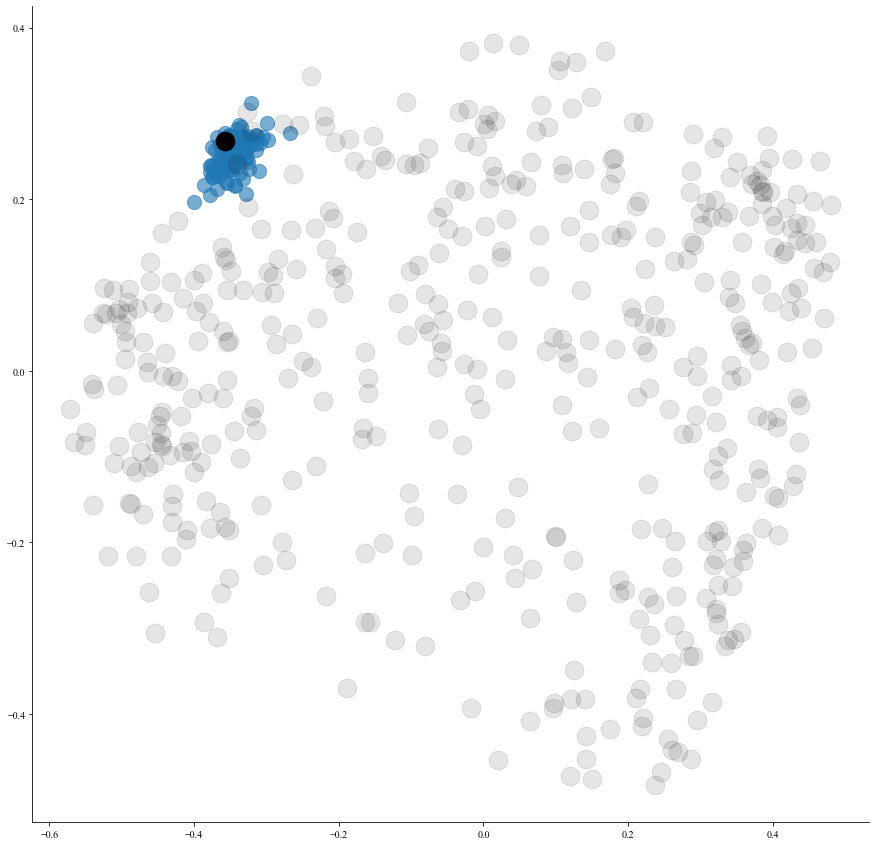

In [123]:
#Visualize epsilon ball around recording

from mpl_toolkits import mplot3d

# colors_range= plt.cm.rainbow(np.linspace(0,1,3))
# colors_ = colors_range[tmspace_cluster]

fig, ax = plt.subplots(1,1,figsize=(15,15))
# ax = plt.axes(projection='3d')
ax.scatter(-1*Xpnew[:,0],-1*Xpnew[:,1],s=200, alpha=0.6)
# ax.scatter(Xp[:,0],Xp[:,1], marker='d', ec='k',s=200, alpha=0.4)
cond=0
cond_recs = [51]
# print(cond_recs)
for i in range(conditions.shape[0]):
#     alpha=0.8
    if i in cond_recs:
        alpha = 1.
    else:
        alpha = .1
    ax.scatter(-1*Xp[i,0].real,-1*Xp[i,1].real,color='k',s=350, alpha=alpha, zorder=30)#, marker=r'${}$'.format(j-start_rec))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Fig4/tmat_space_rec51.pdf')
plt.show()

In [64]:
# Mean distance for all recordings

rec_mean = []
rec_cil = []
rec_ciu = []
n_state=7
delay=1
P_sim = np.zeros((n_state, n_state))
for rec in range(463):
    print(rec)
    mean_js_sim = []
    for s in range(100):
        sim = sims_fish[s,rec,:]
        sim[-1] = ma.masked
        P_sim[:,:] = 0.
        lcs_spec,P_spec = op_calc.transition_matrix(sim,delay=1, return_connected=True)
        for i,l in enumerate(lcs_spec):
            P_sim[l,lcs_spec] = P_spec.todense()[i]
        mean_js_sim.append(np.average(np.sum(np.abs(P_sim - P_prj[rec]), axis=1)))
    rec_mean.append(np.mean(mean_js_sim))
    rec_cil.append(np.nanpercentile(mean_js_sim, 2.5))
    rec_ciu.append(np.nanpercentile(mean_js_sim, 97.5))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

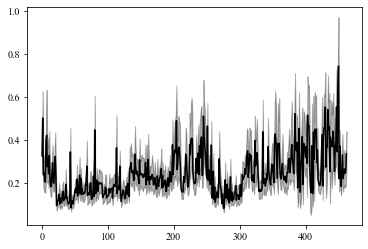

In [126]:
plt.plot(np.asarray(rec_mean), c='k')
plt.fill_between(np.arange(463),np.asarray(rec_cil), np.asarray(rec_ciu),alpha=0.3, color='k')
# plt.ylim(0,9)
# plt.xlim(0,463)
# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Fig4/dendrogram_noise.pdf')

In [186]:
import skfuzzy as fuzz
def fuzzy_split(ev,indices,g_to_split,hard_assign,rb,dict_s):
    c, cr,_,_,_,_,_= fuzz.cmeans(ev[g_to_split][:,np.newaxis].T, 2,m=2,error=0.005,maxiter=1000)
    
    cr_preds = np.zeros((len(np.hstack(indices)),2))
    for i in range(len(ev)):
        if i == g_to_split:
            cr_preds[indices[i],:] = cr.T
        else:
            cr_pred,_,_,_,_,_ = fuzz.cmeans_predict(ev[i][:,np.newaxis].T, c,2,error=0.005,maxiter=1000)
            cr_preds[indices[i],:] = cr_pred.T
    
    new_rb = np.multiply(cr_preds, np.vstack([rb[:,g_to_split],rb[:,g_to_split]]).T)
    not_g_to_split = np.delete(np.arange(len(ev)),g_to_split)
    hard_assign[indices[g_to_split]] = np.argmax(cr,axis=0) + np.max(hard_assign) + 1
    
    dict_s.append([g_to_split,np.arange(len(np.unique(hard_assign))-2, len(np.unique(hard_assign)))])
    
    final_rb = np.zeros((rb.shape[0],len(np.unique(hard_assign))))
    final_rb[:,:len(np.unique(hard_assign))-2] = rb[:,not_g_to_split]
    final_rb[:,len(np.unique(hard_assign))-2:] = new_rb
    
    final_hard_assign = np.zeros(hard_assign.shape,dtype=int)

    for new_idx,label in enumerate(np.sort(np.unique(hard_assign))):
        final_hard_assign[hard_assign==label]=new_idx
        
    return final_hard_assign,final_rb,dict_s



# def fuzzy_split(ev,indices,g_to_split,hard_assign):
#     c, cr,_,_,_,_,_= fuzz.cmeans(ev[g_to_split][:,np.newaxis].T, 2,m=2,error=0.005,maxiter=1000)
#     hard_assign[indices[g_to_split]] = np.argmax(cr,axis=0) + np.max(hard_assign) + 1
    
#     final_hard_assign = np.zeros(hard_assign.shape,dtype=int)
#     for new_idx,label in enumerate(np.sort(np.unique(hard_assign))):
#         final_hard_assign[hard_assign==label]=new_idx
        
#     return final_hard_assign


def hfss(D,point_epsilon,n_groups=None):
    """
    A hierarchical fuzzy spectral clustering by performing fuzzy c-means on the Fiedler vectors from 
    multiple diffusion maps built from a distance matrix
    
    Parameters:
    D: The distance matrix. If the distance is Euclidean feed distance^2
    point_epsilon: The resolution parameter of every datapoint
    n_groups: The number of groups to split into. If None, then split will run until scale separation stops
    
    Returns:
    labels_tree: The cluster labels after a hard assign
    responsibilities: The posterior P(C|X)
    """
    
    eps = np.sqrt(np.outer(point_epsilon,point_epsilon))
    
    P = np.exp(-D/eps)
    P = P / P.sum(axis=1)[:, np.newaxis]
    
    diff_eig, diff_ev = np.linalg.eig(P)
    inv_measure = op_calc.stationary_distribution(P)
    
    diff_eigvecs = diff_ev/np.linalg.norm(diff_ev,axis=0)
    c, cr,_,_,_,_,_= fuzz.cmeans(diff_eigvecs[:,1][:,np.newaxis].T, 2,m=2,error=0.0005,maxiter=1000)
    
    hard_assign = np.argmax(cr,axis=0)
    
    respons = np.zeros((D.shape[0],2))
    respons = cr.T
    
    labels_tree=np.zeros((n_groups,len(hard_assign)),dtype=int)
    labels_tree[0,:] = hard_assign
    response_tree = []
    response_tree.append(respons)
    
    dict_split = []
    lambda_tree = []
    dist_rat_tree = []
    
    for g in range(1, n_groups):
        lambda_2=[]
        eigvecs_groups=[]
        indices_groups=[]
        P_groups=[]
        im_groups = []
        dist_rat = []
        rhos = []
        for g in np.unique(hard_assign):
            idx = np.where(hard_assign == g)[0]
            indices_groups.append(idx)
            eps_part = np.sqrt(np.outer(point_epsilon[idx],point_epsilon[idx]))
            D_part = D[idx,:][:,idx]
            ratio = D_part/eps_part
            P = np.exp(-ratio)
            P = P / P.sum(axis=1)[:, np.newaxis]
            if P.shape[0] == 1:
                lambda_2.append(diff_eig[1])
                eigvecs_groups.append(np.zeros((P.shape[0],)))
            else:
                diff_eig, diff_ev = np.linalg.eig(P)
                diff_eigvecs = diff_ev/np.linalg.norm(diff_ev,axis=0)
                im = op_calc.stationary_distribution(P)
                c, cr,_,_,_,_,_= fuzz.cmeans(diff_eigvecs[:,1].real[:,np.newaxis].T, 2,m=2,error=0.005,maxiter=1000)
                ha = np.argmax(cr,axis=0)
                rho = [(im[ha==k]*(P[ha==k,:][:,ha==k])).sum()/im[ha==k].sum() for k in range(2)]
                rhos.append(np.min(rho))
                im_groups.append(im)
                eigvecs_groups.append(diff_eigvecs[:,1].real)
                lambda_2.append(diff_eig[1])
                P_groups.append(P)
                dist_rat.append(ratio[np.triu_indices(ratio.shape[0],k=1)])
        
        measures = [(inv_measure[hard_assign==g]).sum() for g in np.unique(hard_assign)]
        lambda_tree.append(lambda_2)
        dist_rat_tree.append(dist_rat)
#         print(lambda_2)
#         print(-1/np.log(lambda_2))
        print(rhos)
        g_to_split = np.argmax(rhos)
        hard_assign,respons,dict_split = fuzzy_split(eigvecs_groups,indices_groups,g_to_split,hard_assign,respons,dict_split)
        
        labels_tree[g,:] = np.copy(hard_assign)
        response_tree.append(respons)
        g+=1
    
    return labels_tree, response_tree, lambda_tree,dist_rat_tree

In [204]:
labels_tree, response_tree, lambda_tree,dist_tree = hfss(mean_js_full,np.asarray(rec_mean),n_groups=10)

[0.6795770131799622, 0.612585116327522]
[0.612585116327522, 0.6281633283899745, 0.5473976918071966]
[0.612585116327522, 0.5473976918071966, 0.5376548267651422, 0.47317355170029035]
[0.5473976918071966, 0.5376548267651422, 0.47317355170029035, 0.6415977786056731, 0.6504333674251096]
[0.5473976918071966, 0.5376548267651422, 0.47317355170029035, 0.6415977786056731, 0.4730516390656983, 0.5123035482394982]
[0.5473976918071966, 0.5376548267651422, 0.47317355170029035, 0.4730516390656983, 0.5123035482394982, 0.4956675093814445, 0.4212064669336266]
[0.5376548267651422, 0.47317355170029035, 0.4730516390656983, 0.5123035482394982, 0.4956675093814445, 0.4212064669336266, 0.5378010401193817, 0.5809579971388226]
[0.5376548267651422, 0.47317355170029035, 0.4730516390656983, 0.5123035482394982, 0.4956675093814445, 0.4212064669336266, 0.5378010401193817, 0.4779921933279463, 0.6425308266753326]
[0.5376548267651422, 0.47317355170029035, 0.4730516390656983, 0.5123035482394982, 0.4956675093814445, 0.42120

In [216]:
##Stopping criterion

In [217]:
all_dists = []
for i in range(len(dist_tree)):
    all_dists.append(np.hstack(dist_tree[i]))

In [237]:
import matplotlib.colors as colors

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

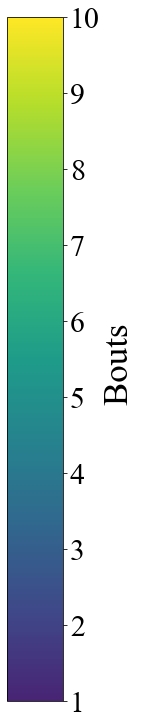

In [241]:
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(1, 25))
fig.subplots_adjust(bottom=0.5)

cmap = truncate_colormap(plt.get_cmap('viridis'), 0.1, 1., n = len(all_dists))
norm = mpl.colors.Normalize(vmin=1, vmax=10)

cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm,
                                orientation='vertical')
cb1.set_label(r'Bouts ',size=35)
# ts = np.arange(50,2050,500)
# print(ts)
# cb1.set_ticks([])
# cb1.ax.set_yticks([0.7,1])
# cb1.set_ticks([1.,11.0])
# cb1.ax.set_yticklabels(['0.0','11.0'])
cb1.ax.tick_params(labelsize=30)
# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Fig1/UMAP_nflip_colorbar.svg')
# fig.show()
plt.show()

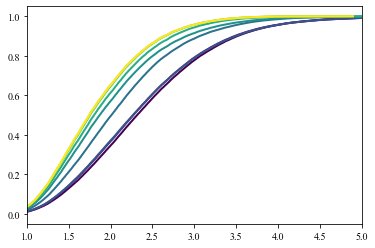

In [226]:
bins = np.linspace(.2,6,10)
colors_ = plt.cm.viridis(np.linspace(0,1,len(all_dists)))
probs_k = []
for i in range(len(avg_dists)):
    x,y = stats.cumulative_dist(all_dists[i],(0,10))
    h,_ = np.histogram(all_dists[i],bins=bins)
    probs_k.append(h)
    plt.plot(x,y,color = colors_[i], lw=2)
plt.xlim(1,5)
plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Fig4/split_criterion_cdf.pdf')
plt.show()

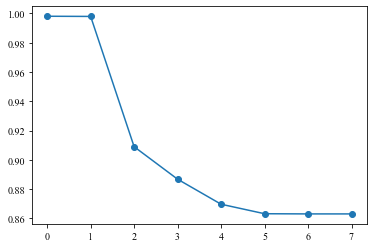

In [221]:
KL_divs=[]
for i in range(len(all_dists)-1):
    sel = np.logical_and(probs_k[i]>0,probs_k[i+1]>0)
    KL_divs.append(stats.KLDiv(probs_k[i][sel],probs_k[i+1][sel]))
plt.plot(1-np.cumsum(KL_divs),marker='o')
plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Fig4/split_criterion_KLdiv.pdf')
plt.show()

Prey capture Rot. RW. (2.5x2.5cm)


<ipython-input-318-222f49a21d1a>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['',''], fontsize=30)
<ipython-input-318-222f49a21d1a>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['',''], fontsize=30)


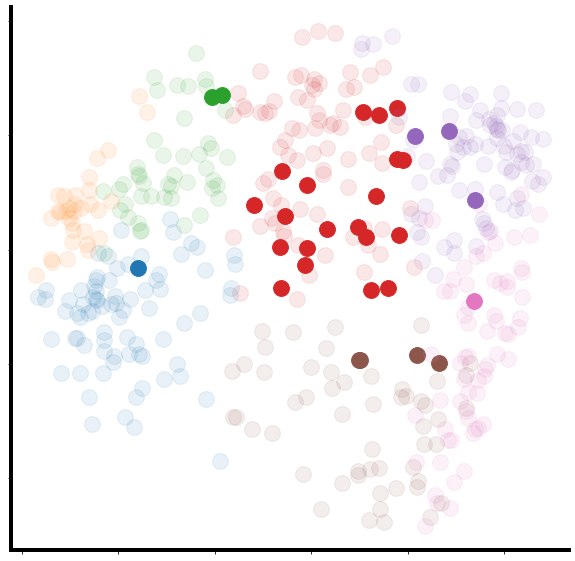

In [318]:
# Visualize Clustering

cond = 14
print(condition_labels[cond])
cond_recs = np.where(conditions[:,1] == condition_labels[cond])[0]

fig, ax = plt.subplots(1,1,figsize=(10,10))
# ax = plt.axes(projection='3d')
# im = ax.scatter(-1*Xp[:,0], -1*Xp[:,1], c=response_tree[2][:,0],cmap='PRGn',s=250, vmax =1., vmin=0)
# fig.colorbar(im)
for i in range(463):
    alpha=.1
    if i in cond_recs:
        alpha = 1.
    ax.scatter(-1*Xp[i,0],-1*Xp[i,1],color='C{}'.format(labels_tree[5][i]),s=250, alpha=alpha)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# ax.view_init(45, 40)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(4)
ax.set_xticklabels(['',''], fontsize=30)
ax.set_yticklabels(['',''], fontsize=30)

# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Fig4/Tmat_space_clustered.pdf')
plt.show()

In [319]:
print(labels_tree[5])

[6 6 0 0 0 0 6 6 4 5 5 5 5 5 3 0 0 0 0 0 5 0 3 0 0 0 0 0 0 0 0 2 3 3 5 2 3
 0 0 3 0 0 0 5 0 0 0 2 0 2 2 1 0 2 1 1 1 1 0 0 0 0 0 2 0 0 2 2 5 2 0 0 1 3
 4 0 0 2 0 2 4 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 2 0 2 2 0 0 1 1 1 3 0 2 2
 2 1 3 0 3 3 2 3 3 2 2 0 2 2 0 0 3 0 2 3 3 0 4 3 3 3 3 3 3 3 3 3 3 3 2 2 2
 4 3 3 3 3 3 3 3 3 3 3 3 3 4 4 2 0 2 1 1 0 4 2 2 2 2 2 2 0 1 0 2 1 4 2 3 2
 1 1 3 2 0 2 0 0 3 4 5 0 5 5 4 6 6 6 6 6 6 6 6 6 6 5 3 3 0 2 3 3 4 4 4 4 3
 3 5 6 6 5 6 6 6 5 3 4 4 4 6 4 6 3 3 4 4 4 3 3 4 4 4 5 5 5 5 3 4 5 0 0 0 4
 4 4 4 4 3 3 3 4 2 4 6 5 6 5 3 3 3 3 3 5 3 3 5 3 3 3 3 4 0 2 3 3 3 5 4 3 3
 5 4 3 2 3 6 3 3 4 4 4 3 3 4 3 5 5 5 4 4 5 5 4 4 4 4 4 3 4 4 4 3 5 3 2 3 3
 3 3 4 4 4 4 4 4 4 5 4 4 4 4 3 4 4 6 4 4 4 4 6 5 4 6 6 6 4 4 4 4 4 3 5 5 5
 4 4 4 4 4 5 4 4 4 6 6 4 4 4 4 4 5 6 6 6 6 6 6 6 6 6 6 5 5 5 5 5 6 5 5 5 6
 6 6 6 6 6 5 6 6 6 5 5 5 5 5 0 0 0 5 6 6 6 6 5 6 6 6 6 6 5 6 6 6 6 6 6 6 4
 0 2 0 3 0 3 3 3 3 1 2 1 1 0 1 1 1 1 1]


In [306]:
np.save('/Users/gautam.sridhar/Documents/Repos/ZebraBouts/Datasets/Full_Data/spectral_split_g7.npy',labels_tree[5])

In [ ]:
# Visualize posterior within cluster


In [2]:
## Visualize behavioral grouos on phi1-phi2

In [244]:
split_locs = []
distorted_eigfs = np.zeros((eigfunctions.shape[0], eigfunctions.shape[1]-1))
for i in range(1,eigfunctions.shape[1]):
    phi = eigfunctions[:,i]
    _,_,_,split_idx,_ = op_calc.optimal_partition(phi,inv_measure,P_ensemble,return_rho=True)

    sort_range = np.sort(phi)
    neg_range = np.linspace(-1,0, len(sort_range[0:split_idx]))
    pos_range = np.linspace(0,1,len(sort_range[split_idx:]))
    distort_r = np.hstack([neg_range,pos_range])
    distort = np.zeros(phi.shape)

    pos = [np.where(phi == a)[0][0] for a in np.sort(phi)]

    for j in range(phi.shape[0]):
        distort[pos[j]] = distort_r[j]

    distorted_eigfs[:,i-1] = distort
    split_locs.append(split_idx)

In [245]:
distorted_trajs = ma.array(distorted_eigfs)[final_labels,:]
distorted_trajs[final_labels.mask] = ma.masked

distorted_fish = distorted_trajs.reshape(labels_fish.shape[0], labels_fish.shape[1], -1)

dtrajs_fish_phi1 = distorted_fish[:,:,0]
dtrajs_fish_phi2 = distorted_fish[:,:,1]

In [305]:
np.linspace(5,100,16)

array([  5.        ,  11.33333333,  17.66666667,  24.        ,
        30.33333333,  36.66666667,  43.        ,  49.33333333,
        55.66666667,  62.        ,  68.33333333,  74.66666667,
        81.        ,  87.33333333,  93.66666667, 100.        ])

<ipython-input-304-c9369c91118a>:17: UserWarning: linewidths is ignored by contourf
  im = ax.contourf(X,Y, img, cmap='Reds', linewidths=2, levels = 17)


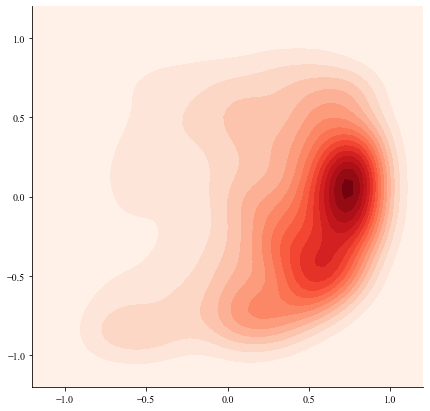

In [304]:
fig, ax  = plt.subplots(1,1,figsize=(7, 7))

xrange=[-1.2, +1.2]
yrange=[-1.2, +1.2]

clus=5
idx = np.where(labels_tree[5] == clus)[0]
maxL = np.max(lengths_rem[idx])
# print(maxL)

psi1 = ma.concatenate(distorted_fish[idx,:maxL,0], axis=0)
psi2 = ma.concatenate(distorted_fish[idx,:maxL,1], axis=0)

img= stats.density_plot(psi1.compressed(), psi2.compressed(), xrange, yrange, 50,50,smooth=True, border=3)

X,Y = np.meshgrid(np.linspace(-1.2,1.2,56), np.linspace(-1.2,1.2,56))
im = ax.contourf(X,Y, img, cmap='Reds', linewidths=2, levels = 17)

# im = ax.imshow(img, cmap='inferno', origin='lower')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Fig4/clus5_mes.pdf')


In [320]:
P_gs = []
for clus in [0,1,2,3,4,5,6]:
    cond_recs = np.where(labels_tree[5] == clus)[0]
#     print(cond_recs)
    lcs_g, P_g = op_calc.transition_matrix(ma.hstack(cluster_fish[cond_recs]),delay=3, return_connected=True)
    P_gs.append(P_g.todense())

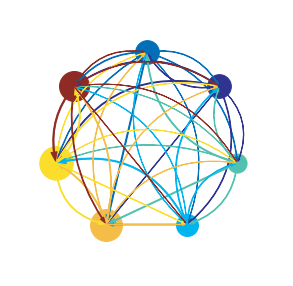

In [341]:
n_states=7
# colors_states_ = ['#1F50A3','#D04D49']
colors_states_ = ['#006FB8','#313390','#52C1AF','#00B4F0','#F4BD48','#FBDD2B','#8D2B24']
# colors_states_ = ['#52C1AF','#F4BD48','#313390','#00B4F0','#FBDD2B','#8D2B24','#006FB8']
# colors_states_ = ['#343B97', '#00B4F0', '#FBDD2B', '#8D2B24']

points = polygon(n_states)

Pc_d = copy.deepcopy(P_gs[2])
ih = op_calc.stationary_distribution(Pc_d)
np.fill_diagonal(Pc_d, 0)
# Pc_d[Pc_d<1e-1]=0
plt.figure(figsize=(5,5))
for k in range(n_states):
    plt.scatter(points[k][0],points[k][1],s=5000*ih[k],c=colors_states_[k], zorder=0)
kx=-1
for idx in range(n_states):
    angle_array = get_angle_array(idx,n_states)*kx
    trans_indices = np.arange(0,n_states)
    trans_indices = trans_indices[trans_indices!=idx]
    for kj,j in enumerate(trans_indices):
        
        draw_curved_arrow(idx,points[idx],points[j],5*Pc_d[idx,j],angle_array[kj],colors_states_)
    kx=kx*-1
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.axis('off')
# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Fig4/tmat_g3.pdf')
plt.show()

In [228]:
## Confusion matrix for each cluster for each condition
group=5
rb = response_tree[group]

In [229]:
colors1_ = plt.cm.autumn(np.linspace(0.0,1.,11))
colors2_ = plt.cm.winter(np.linspace(0.,1.,5))
colors_ = np.vstack([colors1_,colors2_])
means = []
cils = []
cius = []

for j,cond in enumerate([12,11,13,14]):
    cond_recs = np.where(conditions[:,1] == condition_labels[cond])[0]
    cond_resp = rb[cond_recs]
    m,cil,ciu = stats.bootstrap(cond_resp,n_times=1000)
    means.append(m)
    cils.append(cil)
    cius.append(ciu)
means = np.vstack(means).T
cils = np.vstack(cils).T
cius = np.vstack(cius).T

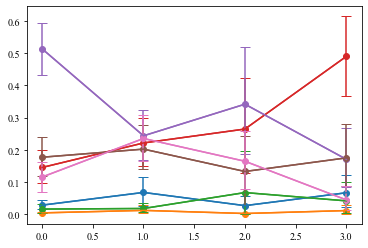

In [231]:
for i in np.arange(7):
    plt.plot(np.arange(len(means[i])),means[i], color = 'C{}'.format(i), marker='o')
    plt.errorbar(np.arange(len(means[i])),means[i],[means[i] - cils[i],cius[i]-means[i]],capsize=5,color='C{}'.format(i))